In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps
from sklearn import linear_model
import os
os.chdir('../')

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
inc_val = 0.0
inc_std = 0.25

D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
def hp_df_to_nf(hp_df):
    nf = NormalizingFlow(
        arch_type=hp_df['arch_type'],
        D=model.D,
        num_stages=int(hp_df['num_stages']),
        num_layers=int(hp_df['num_layers']),
        num_units=int(hp_df['num_units']),
        batch_norm=bool(hp_df['batch_norm']),
        bn_momentum=float(hp_df['bn_momentum']),
        post_affine=bool(hp_df['post_affine']),
        bounds=model._get_bounds(),
        random_seed=int(hp_df['random_seed']),
    )
    return nf

def hp_df_to_aug_lag_hps(hp_df):
    aug_lag_hps = AugLagHPs(
        N=int(hp_df['N']), 
        lr=hp_df['lr'], 
        c0=hp_df['c0'], 
        gamma=hp_df['gamma'], 
        beta=hp_df['beta'],
    )
    return aug_lag_hps

In [4]:
nu = .5

hp_df_rows = []
ks = []
for alpha in alphas:
    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    hp_df, opt_df = model.get_epi_dfs(mu, prefix='V1Circuit/')
    best_ind = None
    best_k = None
    maxH = None
    i = 0
    for _, hp_df_i in hp_df.iterrows():
        nf = hp_df_to_nf(hp_df_i)
        aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_i)
        k, conv = model.get_convergence_epoch(
            mu, 
            nf, 
            aug_lag_hps, 
            prefix='V1Circuit/', 
            nu=nu, 
        )
        print(k)
        z, log_prob = nf(aug_lag_hps.N)
        H = np.mean(-log_prob)
        if (conv and maxH is None or H > maxH):
            best_ind = i
            maxH = H
            est_k = k
            
        i += 1
    ks.append(best_k)
    hp_df_rows.append(hp_df.iloc[best_ind])


Checking in V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/.
skipping V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/extra/hps.p
Found 1 optimizations.
k 0
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
[False False]
k 1
[False False]
k 2
[False False]
k 3
[False False]
k 4


KeyboardInterrupt: 

In [ ]:
print(H)

In [18]:
q_thetas = []
for i in range(num_alphas):
    alpha = alphas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    q_thetas.append(q_theta)

NameError: name 'hp_df_rows' is not defined

In [5]:
from epi.example_eps import V1_ISN, V1_sim

[0.62171173 0.55912626 1.0424461  0.38153827]
tf.Tensor([[0.9091663]], shape=(1, 1), dtype=float32)


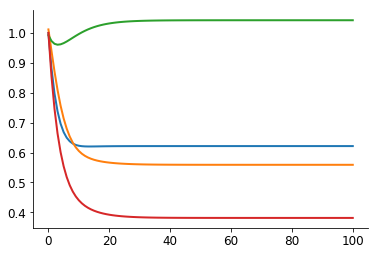

In [6]:
r_t = V1_sim(np.zeros((1,4))).numpy()
plt.plot(r_t[0].T)
print(r_t[0,:,-1])
print(V1_ISN(np.zeros((1,4))))

In [48]:
npzfile = np.load("../data/V1/V1_Zs.npz")
W = npzfile["Z_allen_square"][None, :, :]
W[:, :, 1:] = -W[:, :, 1:]

name = "V1Circuit"
dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
model = Model(name, parameters)

model.set_eps(V1_ISN)
dh = np.random.normal(0., 1, (1000,4))
T = model.eps(dh).numpy()[:,0]
good = np.logical_not(np.isnan(T))
T = T[good]
dh = dh[good]

inds = np.argsort(T)
print(T[inds][:10])
k = 100
print(dh[inds[k]])
print(T[inds[k]])

[-10.972101  -10.727526   -9.214701   -9.026822   -7.7306614  -7.6090584
  -7.5500345  -7.528159   -7.085223   -6.857291 ]
[ 1.35970185 -0.0930533  -1.54745932 -0.9392151 ]
-1.5525365


[1.9516258  2.916649   0.01631375 4.3174877 ]


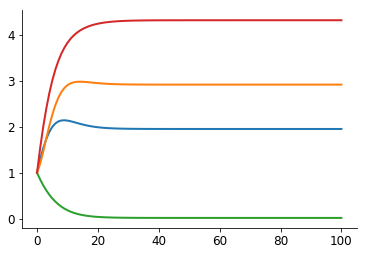

In [49]:
r_t = V1_sim(h[inds[k]][None,:]).numpy()
plt.plot(r_t[0].T)
print(r_t[0,:,-1])

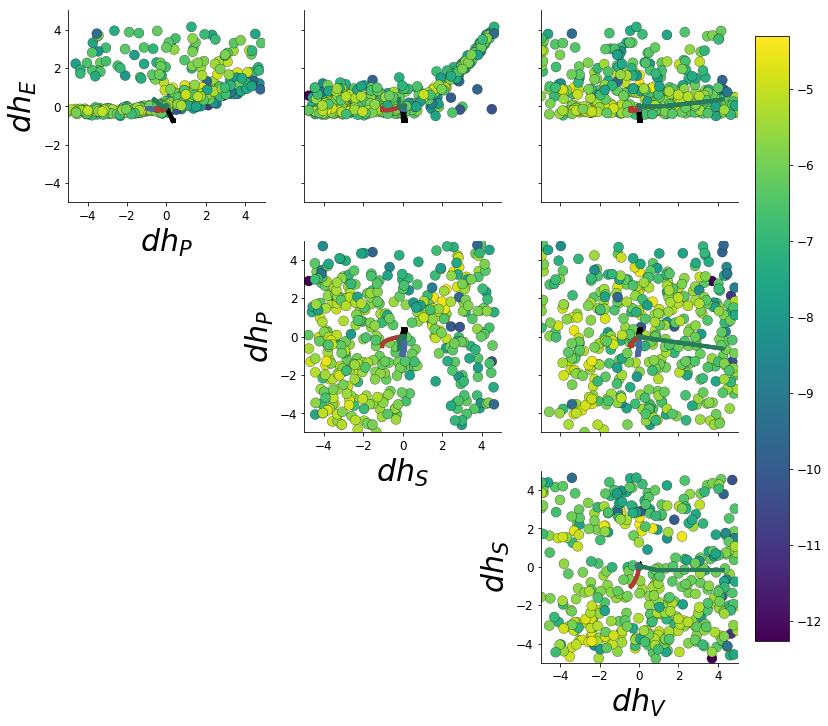

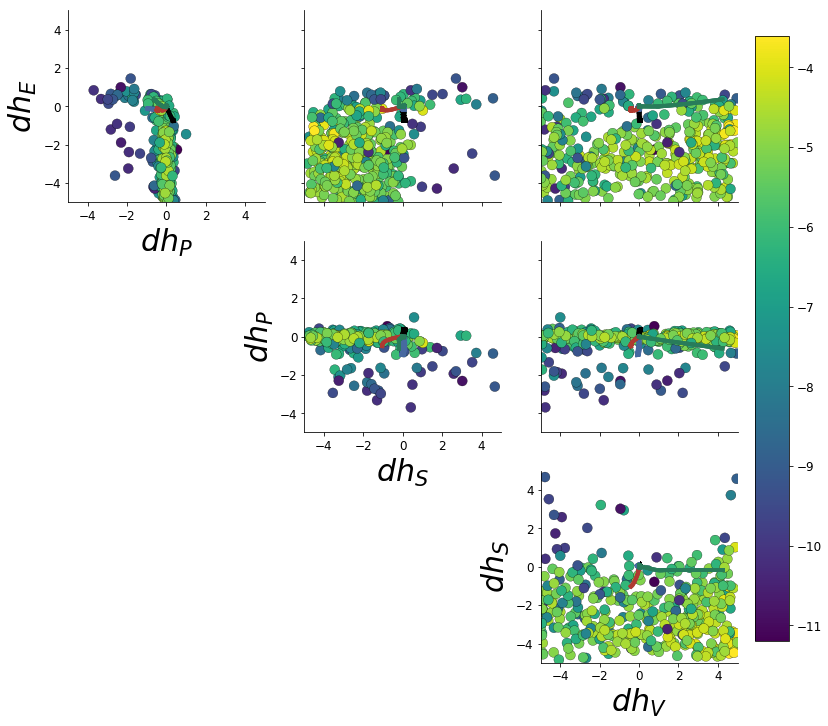

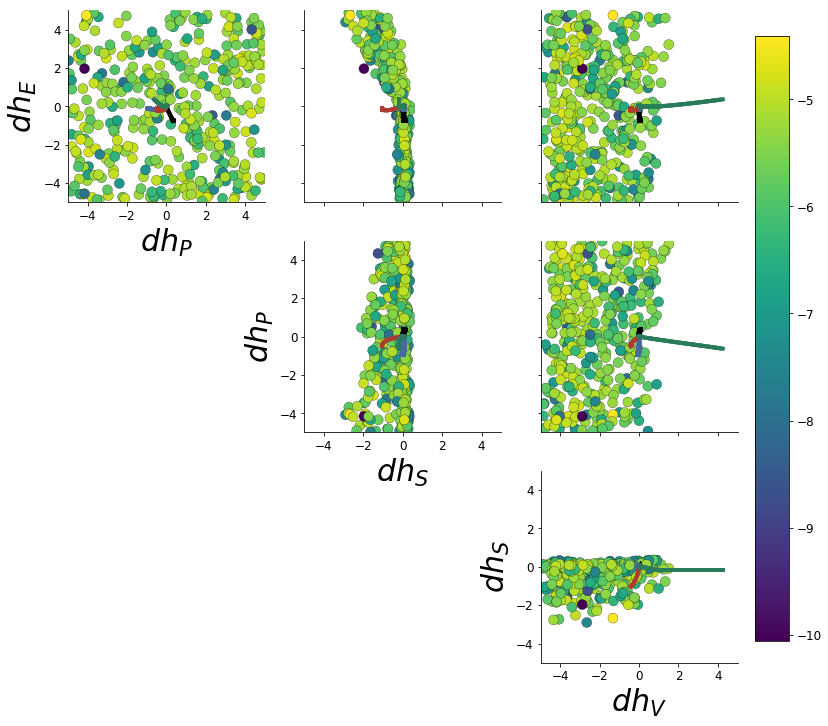

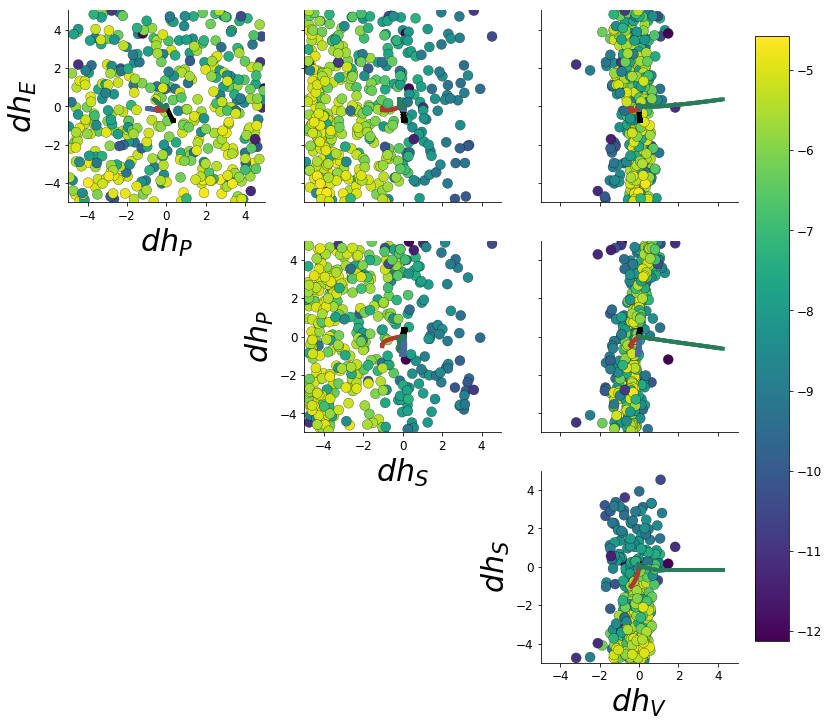

In [44]:
for i in range(4):
    alpha = alphas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )

    # Get samples
    _N = 400
    z = q_theta.sample(_N)
    log_prob = q_theta.log_prob(z)

    dims = range(D)
    z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
    fig = pairplot(z, dims, z_labels,
       z1=z1s.T, z2=z2s.T,
       c_traj=c_traj,
       xlims=[-5, 5], ylims=[-5, 5],
       c_label = '',
       c=log_prob, fontsize=30
    )

### Hess path

In [6]:
"""K = 10
zs = np.zeros((num_alphas, num_alphas, K+1))
beta = 0.5

signs = [-1,1,-1,-1]
for k in range(K):
    for i in range(num_alphas):
        z_ik = zs[i,:,k][None,:]
        hess = np.zeros((num_alphas, num_alphas))
        for j in range(num_alphas):
            hess_j = q_thetas[j].hessian(z_ik)[0]
            if i==j:
                hess += hess_j
            else:
                hess -= hess_j



        w, v = np.linalg.eig(hess)
        eigsort = np.argsort(w)
        w = w[eigsort]
        v = v[:, eigsort]
        v1 = v[:,0]
        if signs[i]*v1[i] < 0.:
            v1 = -v1
        zs[i,:,k+1] = z_ik + beta*v1
        
"""

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### EPI grad path

In [22]:
K = 50
zs_EPI = np.zeros((num_alphas, num_alphas, K+1))
beta = 0.1

for k in range(K):
    for i in range(num_alphas):
        z_ik = zs_EPI[i,:,k][None,:]
        grad = np.zeros((num_alphas,))
        for j in range(num_alphas):
            grad_j = q_thetas[j].gradient(z_ik)[0]
            grad_j = grad_j / np.linalg.norm(grad_j)
            if i==j:
                grad -= grad_j
            else:
                grad += grad_j
        grad = grad/np.linalg.norm(grad)
        zs_EPI[i,:,k+1] = z_ik + beta*grad
        

### No EPI path


### Random

In [31]:
name = "V1Circuit"
dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
model = Model(name, parameters)

dr = V1_all_dr_eps(inc_val)
model.set_eps(dr)


#beta = 0.5
z0 = np.random.normal(0., 0.001, (1,4)).astype(np.float32)
zs_model = np.zeros((num_alphas, num_alphas, K+1), dtype=np.float32)
for i in range(num_alphas):
    zs_model[i,:,0] = z0[0]
    
for i in range(num_alphas):
    for k in range(K):
        z_ik = zs_model[i,:,k]
        z = tf.Variable(initial_value=z_ik[None,:], trainable=True)
        with tf.GradientTape() as tape:
            dx = model.eps(z)[0]
            L = 0.
            for j in range(num_alphas):
                if i == j:
                    L += dx[j]**2
                else:
                    L -= dx[j]**2
            grad = tape.gradient(L, z)[0].numpy()
            v = grad / np.linalg.norm(grad)
            zs_model[i,:,k+1] = z_ik + beta*v
            


In [97]:
#np.savez('hess_paths.npz', zs=zs)

In [43]:
import matplotlib 
z1s = zs_model[:,:,:K]
z2s = zs_model[:,:,1:]

z1s = np.reshape(np.transpose(z1s, [1,0,2]), (num_alphas, num_alphas*K))
z2s = np.reshape(np.transpose(z2s, [1,0,2]), (num_alphas, num_alphas*K))

c_traj = np.ones((num_alphas*K,3))
for i in range(num_alphas):
    for k in range(K):
        c_traj[i*K+k] = matplotlib.colors.to_rgb(colors[i])

### Start control comparisons here

In [25]:
name = "V1Circuit"
dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
model = Model(name, parameters)

dr = V1_all_dr_eps(inc_val)
model.set_eps(dr)

#npzfile = np.load("hess_paths.npz")
#zs = npzfile['zs']
K = zs_EPI.shape[2]-1


### Generate random data

In [26]:
num_rand = 50
zs_rand = np.zeros((num_alphas, num_alphas, num_rand, K+1))

vecs = np.random.normal(0., 1., (num_alphas, num_alphas, num_rand, K+1))
vecs = vecs / np.linalg.norm(vecs, axis=3)[:,:,:,None]

for i in range(num_alphas):
    for n in range(num_rand):
        for k in range(K):
            zk = zs_rand[i,:,n,k]
            v = vecs[i,:,n,k]
            #if signs[i]*v[i] < 0.:
            #    v = -v
            zs_rand[i,:,n,k+1] = zk + beta*v

In [40]:
diffs_alpha = []
diffs_rest = []

diffs_model_alpha = []
diffs_model_rest = []

diffs_alpha_mean = []
diffs_alpha_var = []
diffs_rest_mean = []
diffs_rest_var = []

dxs = []
dxs_model = []
for i in range(num_alphas):
    alpha = alphas[i]
    
    # Grad path responses
    dx = model.eps(zs_EPI[i].T)
    dxs.append(dx)
    _diffs_rest = np.zeros((K+1,))
    for j in range(num_alphas):
        if (i==j):
            diffs_alpha.append(np.square(dx[:,j]))
        else:
            _diffs_rest += np.square(dx[:,j])
    diffs_rest.append(_diffs_rest)
    
    # Grad path responses
    dx = model.eps(zs_model[i].T)
    dxs_model.append(dx)
    _diffs_model_rest = np.zeros((K+1,))
    for j in range(num_alphas):
        if (i==j):
            diffs_model_alpha.append(np.square(dx[:,j]))
        else:
            _diffs_model_rest += np.square(dx[:,j])
    diffs_model_rest.append(_diffs_model_rest)
    
    
    # Random responses.
    zs_rand_i = np.reshape(zs_rand[i], (num_alphas, num_rand*(K+1)))
    dx = model.eps(zs_rand_i.T)
    dx = np.reshape(dx, (num_rand, K+1, dx.shape[1]))[:,:,:4]
    
    _diffs_rest_mean = np.zeros((K+1,))
    _diffs_rest = np.zeros((num_rand, K+1,))
    for j in range(num_alphas):
        if i==j:
            diffs_alpha_mean.append(np.mean(np.square(dx[:,:,j]), axis=0))
            diffs_alpha_var.append(np.std(np.square(dx[:,:,j]), axis=0)/np.sqrt(num_rand))
        else:
            _diffs_rest_mean += np.mean(np.square(dx[:,:,j]), axis=0)
            _diffs_rest += np.square(dx[:,:,j])
    diffs_rest_mean.append(_diffs_rest_mean)
    diffs_rest_var.append(np.std(_diffs_rest, axis=0) / np.sqrt(num_rand))
    
    
diffs_alpha = np.array(diffs_alpha)
diffs_rest = np.array(diffs_rest)

diffs_alpha_mean = np.array(diffs_alpha_mean)
diffs_alpha_var = np.array(diffs_alpha_var)
diffs_rest_mean = np.array(diffs_rest_mean)
diffs_rest_var = np.array(diffs_rest_var)


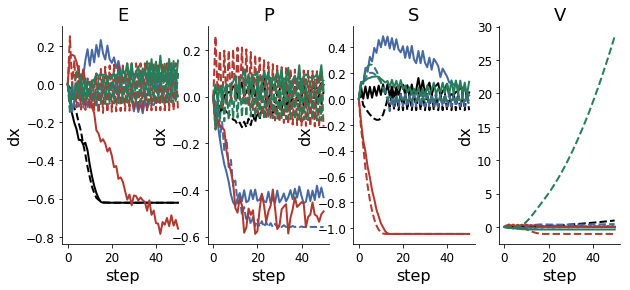

In [41]:
fig, axs = plt.subplots(1,4,figsize=(10,4))
for i in range(num_alphas):
    ax = axs[i]
    alpha = alphas[i]
    
    for j in range(num_alphas):
        ax.plot(dxs[i][:,j], c=colors[j])
        ax.plot(dxs_model[i][:,j], '--', c=colors[j])
    ax.set_xlabel('step')
    ax.set_ylabel('dx')
    ax.set_title(alpha)

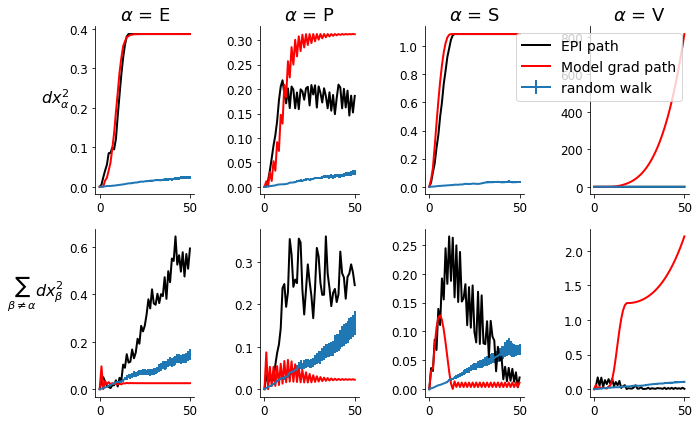

In [42]:
fig, axs = plt.subplots(2,4,figsize=(10,6))
for i in range(num_alphas):
    alpha = alphas[i]
    axs[0,i].plot(diffs_alpha[i], 'k-')
    axs[0,i].plot(diffs_model_alpha[i], 'r-')
    axs[0,i].errorbar(np.arange(K+1), diffs_alpha_mean[i], diffs_alpha_var[i])
    axs[1,i].plot(diffs_rest[i], 'k-')
    axs[1,i].plot(diffs_model_rest[i], 'r-')
    axs[1,i].errorbar(np.arange(K+1), diffs_rest_mean[i], diffs_rest_var[i])
    axs[0,i].set_title(r'$\alpha$ = %s' % alpha)
    
axs[0,0].set_ylabel(r'$dx_\alpha^2$', rotation=0)
axs[0,0].yaxis.set_label_coords(-0.4,0.5)
axs[1,0].set_ylabel(r'$\sum_{\beta \neq \alpha} dx_{\beta}^2$', rotation=0)
axs[1,0].yaxis.set_label_coords(-0.6,0.5)

axs[0,-1].legend(['EPI path', 'Model grad path', 'random walk'])
plt.tight_layout()
plt.show()